<a href="https://colab.research.google.com/github/Venuram/Machine-Learning-Projects/blob/master/NetFlix_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>1. Business Problem </h1>

<h2> 1.1 Problem Description </h2>

<p>
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while <b>Cinematch</b> is doing pretty well, it can always be made better.
</p>
<p>Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>
<p> Credits: https://www.netflixprize.com/rules.html </p>

<h2> 1.2 Problem Statement </h2>

<p>
Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.) 
</p>

<ul>
<li> https://www.netflixprize.com/rules.html</li>
<li> https://www.kaggle.com/netflix-inc/netflix-prize-data</li>
<li> Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)</li>
<li>surprise library: http://surpriselib.com/ (we use many models from this library)</li>
<li>surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)</li>
<li>installing surprise: https://github.com/NicolasHug/Surprise#installation </li>
<li> Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)</li>
<li> SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c </li>
</ul>

<h2>1.4 Real world/Business Objectives and constraints  </h2>

Objectives:
1. Predict the rating that a user would give to a movie that he ahs not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)
<br>

Constraints:
1. Some form of interpretability.

<h1> 2. Machine Learning Problem </h1>

<h2>2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> Get the data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data </p>
<p> Data files : 
<ul> 
<li> combined_data_1.txt </li>
<li> combined_data_2.txt </li>
<li> combined_data_3.txt </li>
<li> combined_data_4.txt </li>
<li> movie_titles.csv </li>
</ul>
<pre>  
The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD.
</pre>

In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h2>2.2 Mapping the real world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<pre>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</pre>

<h3> 2.2.2 Performance metric </h3>

<ul>
<li> Mean Absolute Percentage Error: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error </li>
<li> Root Mean Square Error: https://en.wikipedia.org/wiki/Root-mean-square_deviation </li>
</ul>


<h3> 2.2.3 Machine Learning Objective and Constraints </h3>

1. Minimize RMSE.
2. Try to provide some interpretability.

In [3]:
from google.colab import drive # Mounting to drive. 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv(open('drive/My Drive/Applied AI/data_folder/data.csv','rU'), sep=',', 
                       names=['movie', 'user','rating','date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Preprocessing</h2> 

<h3>3.1.1 Converting / Merging whole data to required format</h3>

In [5]:
df.sort_values(by='date', inplace=True)
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [7]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h3>3.1.2 Checking for NaN values </h3>

In [8]:
print('Nan Values in our dataframe:', sum(df.isnull().any()))

Nan Values in our dataframe: 0


<h3>3.1.3 Removing Duplicates </h3>

In [9]:
duplicate_check = df.duplicated(['movie', 'user', 'rating'])
duplic = sum(duplicate_check)
print('There are {} duplicates in the dataframe'.format(duplic))

There are 0 duplicates in the dataframe


 <h3>3.1.4 Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [10]:
print('Total no of ratings', df.shape[0])
print('No of Users', len(np.unique(df.user)))
print('No of Movies', len(np.unique(df.movie)))

Total no of ratings 100480507
No of Users 480189
No of Movies 17770


<h2>3.2 Spliting data into Train and Test(80:20) </h2>

In [0]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

In [0]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv')

In [9]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


<h3>3.2.1 Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [10]:
print('Total no of ratings', train_df.shape[0])
print('No of Users', len(np.unique(train_df.user)))
print('No of Movies', len(np.unique(train_df.movie)))

Total no of ratings 80384405
No of Users 405041
No of Movies 17424


In [15]:
print('Total no of ratings', test_df.shape[0])
print('No of Users', len(np.unique(test_df.user)))
print('No of Movies', len(np.unique(test_df.movie)))

Total no of ratings 20096102
No of Users 349312
No of Movies 17757


 <h2> 3.3 Exploratory Data Analysis on Train data </h2>

In [0]:
def human(num, units):
  units = units.lower()
  num = float(num)
  if units == 'k':
    return str(num/10**3) + 'K'
  elif units == 'm':
    return str(num/10**6) + 'M'
  elif units == 'b':
    return str(num/10**9) + 'B'

In [17]:
human(10700, 'k')

'10.7K'

<h3> 3.3.1 Distribution of ratings </h3>

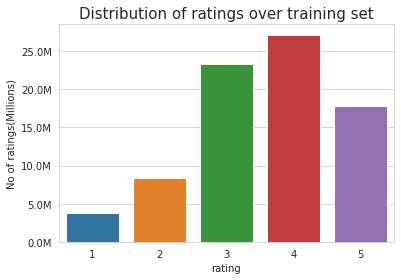

In [18]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over training set', fontsize = 15)
sns.countplot(x = 'rating', data = train_df)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No of ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [12]:
pd.options.mode.chained_assignment = None

train_df['day_of_week'] = train_df['date'].dt.day_name()
train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


<h3> 3.3.2 Number of Ratings per a month </h3>

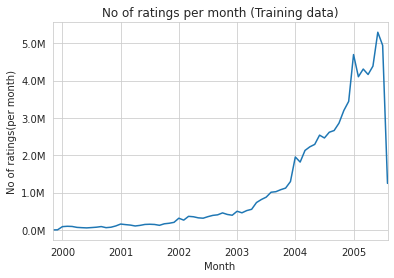

In [20]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'm') for item in ax.get_yticks()])
plt.show()

In [0]:
a = train_df.resample('m', on='date')['rating'].count()

In [22]:
for i in range(0,100,10):  
  var = a.values
  #var = np.sort(var, axis=None)
  print('{} percentile value is {}'.format(i, var[int(len(var)* float(i/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 28
10 percentile value is 54327
20 percentile value is 157111
30 percentile value is 145962
40 percentile value is 363723
50 percentile value is 456118
60 percentile value is 733769
70 percentile value is 1295785
80 percentile value is 2463521
90 percentile value is 4104160
100 percentile value is  1246468


In [23]:
for i in range(90,100):  
  var = a.values
  #var = np.sort(var, axis=None)
  print('{} percentile value is {}'.format(i, var[int(len(var)* float(i/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 4104160
91 percentile value is 4104160
92 percentile value is 4310242
93 percentile value is 4163988
94 percentile value is 4163988
95 percentile value is 4388899
96 percentile value is 5296431
97 percentile value is 5296431
98 percentile value is 4945586
99 percentile value is 1246468
100 percentile value is  1246468


<h3> 3.3.3 Analysis on the Ratings given by user </h3>

In [24]:
no_of_movies_rated_by_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_movies_rated_by_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

Text(0.5, 1.0, 'CDF')

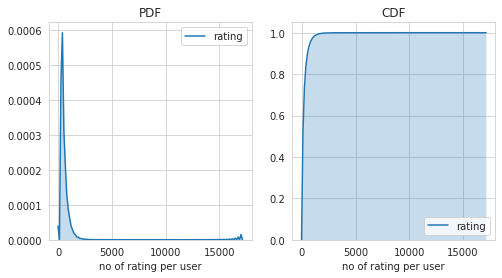

In [25]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_movies_rated_by_user, shade=True, ax=ax1)
plt.xlabel('no of rating per user')
plt.title('PDF')

ax2 = plt.subplot(122)
sns.kdeplot(no_of_movies_rated_by_user, shade=True, cumulative=True, ax=ax2)
plt.xlabel('no of rating per user')
plt.title('CDF')

In [26]:
no_of_movies_rated_by_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [0]:
quantiles = no_of_movies_rated_by_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

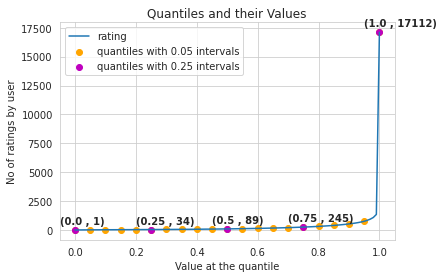

In [28]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [29]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

__how many ratings at the last 5% of all ratings__??

In [30]:
print('No of ratings given by 5 percentile user {}'.format(sum(no_of_movies_rated_by_user > 749)))

No of ratings given by 5 percentile user 20242


<h3> 3.3.4 Analysis of ratings of a movie given by a user </h3>

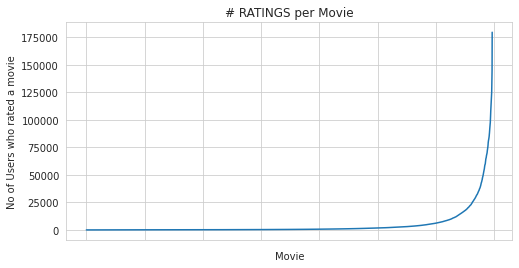

In [31]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- __It is very skewed.. just like nunmber of ratings given per user.__
    
    
    - There are some movies (which are very popular) which are rated by huge number of users.
    
    - But most of the movies(like 90%) got some hundereds of ratings.

<h3> 3.3.5 Number of ratings on each day of the week</h3>

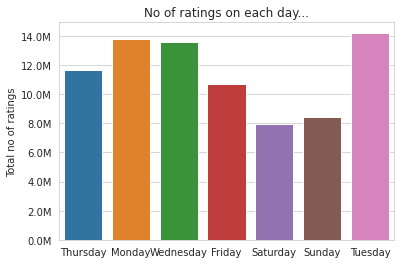

In [32]:
fig, ax = plt.subplots()

sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

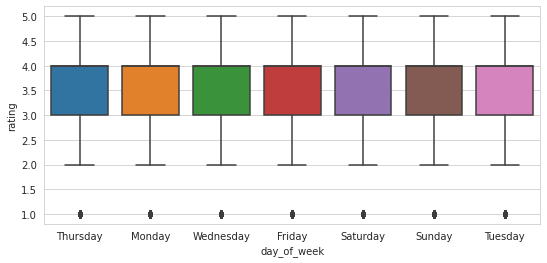

In [33]:
fig = plt.figure(figsize=plt.figaspect(0.45))
sns.boxplot(x='day_of_week', y='rating', data=train_df)
plt.show()

In [34]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(avg_week_df)

day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64


<h3> 3.3.5 Number of ratings on each day of the week</h3>

<h3> 3.3.6 Creating sparse matrix from data frame </h3>

In [13]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:04.321638


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [36]:
us, mv = train_sparse_matrix.shape
elements = train_sparse_matrix.count_nonzero()

print('Sparsity of Matrix:', (1 - (elements/(us*mv))) * 100)

Sparsity of Matrix: 99.8292709259195


<h4> 3.3.6.2 Creating sparse matrix from test data frame </h4>

In [14]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:01.178850


<p><b>The Sparsity of Test data Matrix</b></p>

In [38]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3>3.3.7 Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [0]:
def get_global_avg_rating(sparse_matrix, users):
  ax = 1 if users else 0
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  is_rated = sparse_matrix != 0
  no_of_ratings = is_rated.sum(axis=ax).A1
  u, m = sparse_matrix.shape
  average_rating = { i : sum_of_ratings[i]/no_of_ratings[i] for i in range(u if users else m) if no_of_ratings[i] != 0}
  return average_rating

<h4> 3.3.7.1 finding global average of all movie ratings </h4>

In [58]:
train_average = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_average['global'] = train_global_average
train_average

{'global': 3.582890686321557}

<h4> 3.3.7.2 finding average rating per user</h4>

In [59]:
train_average['user'] = get_global_avg_rating(train_sparse_matrix, users=True)
print('The average rating of user 10:', train_average['user'][10])

The average rating of user 10: 3.3781094527363185


<h4> 3.3.7.3 finding average rating per movie</h4>

In [42]:
train_average['movie'] = get_global_avg_rating(train_sparse_matrix, users=False)
print('The average rating of movie 10', train_average['movie'][10])

The average rating of movie 10 3.1945701357466065


<h4> 3.3.7.4 PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

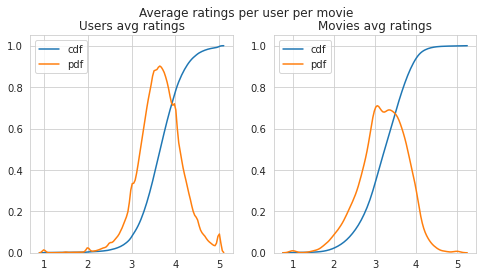

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5))
fig.suptitle('Average ratings per user per movie')

ax1.set_title('Users avg ratings')
user_avg = [i for i in train_average['user'].values()]
sns.distplot(user_avg, ax=ax1, hist=False, kde_kws=dict(cumulative=True), label='cdf')
sns.distplot(user_avg, ax=ax1, hist=False, label='pdf')

ax2.set_title('Movies avg ratings')
user_avg = [i for i in train_average['movie'].values()]
sns.distplot(user_avg, ax=ax2, hist=False, kde_kws=dict(cumulative=True), label='cdf')
sns.distplot(user_avg, ax=ax2, hist=False, label='pdf')

plt.show()

In [44]:
total_users = len(np.unique(df.user))
user_train = len(train_average['user'])
new_users = (total_users - user_train)

print('Total No of unique users:', total_users)
print('Total No of users in training set', user_train)
print('New users in the data: {}({}%)'.format(new_users, (np.round((new_users/total_users) * 100, 2))))

Total No of unique users: 480189
Total No of users in training set 405041
New users in the data: 75148(15.65%)


> We might have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

In [45]:
total_movies = len(np.unique(df.movie))
movie_train = len(train_average['movie'])
new_movies = (total_movies - movie_train)

print('Total No of unique movies:', total_movies)
print('Total No of users in training set', movie_train)
print('New users in the data: {} ({}%)'.format(new_movies, (np.round((new_movies/total_movies) * 100, 2))))

Total No of unique movies: 17770
Total No of users in training set 17424
New users in the data: 346 (1.95%)


<h3> 3.4.1 Computing User-User Similarity matrix </h3>

1. Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_) because of number of. usersbeing lare.

    * You can try if you want to. Your system could crash or the program stops with **Memory Error**


<h4> 3.4.1.1 Trying with all dimensions (17k dimensions per user) </h4>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) # we don't have to
    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user') 
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:00:57.916541  ]
computing done for 40 users [  time elapsed : 0:01:54.412727  ]
computing done for 60 users [  time elapsed : 0:02:49.532131  ]
computing done for 80 users [  time elapsed : 0:03:45.110968  ]
computing done for 100 users [  time elapsed : 0:04:41.389682  ]
Creating Sparse matrix from the computed similarities


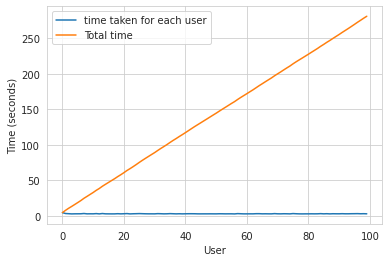

----------------------------------------------------------------------------------------------------
Time taken : 0:04:52.079749


In [47]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

<h4> 3.4.1.2 Trying with reduced dimensions (Using TruncatedSVD for dimensionality reduction of user vector)</h4>

In [17]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
  print('It seems you dont have that file Computing movie_movie similarity...')
  start = datetime.now()
  m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
  print('Done..')
  # store this sparse matrix in disk before using it. For future purposes.
  print('Saving it to disk without the need of re-computing it again.. ')
  sparse.save_npz('m_m_sim_sparse.npz', m_m_sim_sparse)
  print('Done..')
else:
  print("It is there, We will get it.")
  m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
  print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:00:50.700458


In [18]:
m_m_sim_sparse.shape

(17771, 17771)

In [50]:
pip install scikit-surprise

In [0]:
movie_id = np.unique(m_m_sim_sparse.nonzero()[1])

In [21]:
movie_id

array([    1,     2,     3, ..., 17768, 17769, 17770], dtype=int32)

<h3> 3.4.2 Computing Movie-Movie Similarity matrix </h3>

In [28]:
similar_movies = dict()
for id in movie_id:
  sim_movies = m_m_sim_sparse[id].toarray().ravel().argsort()[::-1][1:]
  similar_movies[id] = sim_movies[:100]
  #similar_movies[id] = similar_movies[id].sort()

similar_movies[15]

array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

<h3> 3.4.3 Finding most similar movies using similarity matrix </h3>

__ Does Similarity really works as the way we expected...? __ <br>
_Let's pick some random movie and check for its similar movies...._

In [30]:
movie_titles = pd.read_csv('drive/My Drive/Applied AI/data_folder/movie_titles.csv', sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 5.71 ms
Type conversion took: 18.12 ms
Parser memory cleanup took: 0.05 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [35]:
movie_id = 12

print('Movie -->', movie_titles.loc[movie_id].values[1])
print('No of ratings:', train_sparse_matrix[:,movie_id].getnnz())
print('No of movies similar to this movie', m_m_sim_sparse[:,movie_id].getnnz())

Movie --> My Favorite Brunette
No of ratings: 459
No of movies similar to this movie 17298


In [0]:
similarities = m_m_sim_sparse[movie_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1) and return its indices(movie_ids)

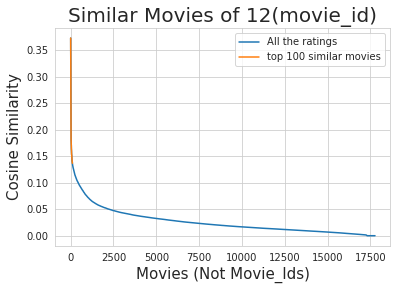

In [46]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(movie_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

__Top 10 similar movies__

In [47]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
90,1951.0,The Lemon Drop Kid
17107,1940.0,The Ghost Breakers
9941,1948.0,Sorrowful Jones / The Paleface: Double Feature
14689,1952.0,Son of Paleface
14023,1952.0,The Road to Bali
10671,1942.0,My Favorite Blonde / Star Spangled Rhythm
12332,1941.0,Road to Zanzibar
17290,1948.0,The Paleface
4536,1947.0,Road to Rio


 <h1> 4.  Machine Learning Models </h1>

In [0]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2> 4.1 Sampling Data </h2>

<h3>4.1.1 Build sample train data from the train data</h3>

In [50]:
start = datetime.now()
path = "drive/My Drive/Applied AI/data_folder/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.698766


<h3>4.1.2 Build sample test data from the test data</h3>

In [51]:
start = datetime.now()

path = "drive/My Drive/Applied AI/data_folder/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample/small/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.275863


<h2>4.2 Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [0]:
sample_train_averages = dict()

<h3>4.2.1 Finding Global Average of all movie ratings</h3>

In [53]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

<h3>4.2.2 Finding Average rating per User</h3>

In [60]:
sample_train_averages['user'] = get_global_avg_rating(sample_train_sparse_matrix, users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


<h3>4.2.3 Finding Average rating per Movie</h3>

In [62]:
sample_train_averages['movie'] =  get_global_avg_rating(sample_train_sparse_matrix, users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.6458333333333335


<h2> 4.3 Featurizing data </h2>

In [63]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 129286


 No of ratings in Our Sampled test  matrix is : 7333



<h3> 4.3.1 Featurizing data for regression problem </h3>

<h4> 4.3.1.1 Featurizing train data </h4>

In [0]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [67]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('drive/My Drive/Applied AI/data_folder/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('drive/My Drive/Applied AI/data_folder/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001245


__Reading from the file to make a Train_dataframe__

In [68]:
reg_train = pd.read_csv('drive/My Drive/Applied AI/data_folder/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

In [0]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [70]:
start = datetime.now()

if os.path.isfile('drive/My Drive/Applied AI/data_folder/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('drive/My Drive/Applied AI/data_folder/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [71]:
reg_test_df = pd.read_csv('drive/My Drive/Applied AI/data_folder/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h3> 4.3.2 Transforming data for Surprise models</h3>

In [0]:
from surprise import Reader, Dataset

In [0]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.1 Transforming train data </h4>

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [75]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 4.4 Applying Machine Learning models </h2>

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [80]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [0]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

> __Utility functions for Surprise modes__

In [0]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [0]:
import xgboost as xgb

Training the model..
[15:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:03.626916

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.076373581778953
MAPE :  34.48223172520999


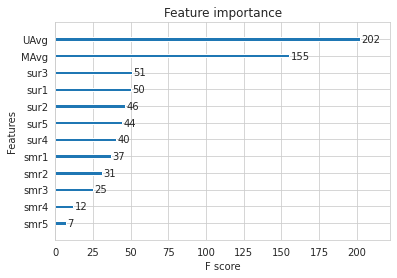

In [81]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [0]:
from surprise import BaselineOnly 

In [84]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.973148 

Evaluating the model with train data..
time taken : 0:00:01.112549
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.061939
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.148882


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [85]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


__Updating Test Data__

In [86]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


Training the model..
[16:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:04.281029

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0765603714651855
MAPE :  34.4648051883444


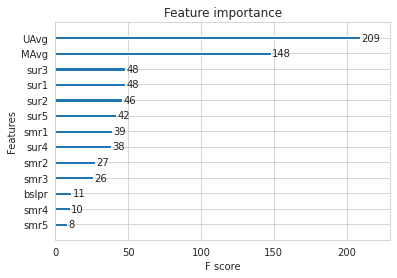

In [87]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [0]:
from surprise import KNNBaseline

In [89]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:31.627386 

Evaluating the model with train data..
time taken : 0:01:42.537136
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.065795
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:14.231553


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [90]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.220304 

Evaluating the model with train data..
time taken : 0:00:09.223248
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.065648
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:10.510879


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

In [91]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302


In [92]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679


Training the model..
[16:27:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:04.830200

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0767793575625662
MAPE :  34.44745951378593


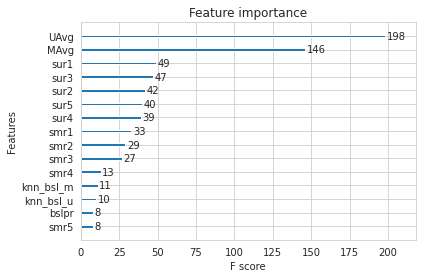

In [93]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [0]:
from surprise import SVD

In [95]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.777939 

Evaluating the model with train data..
time taken : 0:00:01.374519
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660474

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.061812
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.215580


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [0]:
from surprise import SVDpp

In [97]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:02.035252 

Evaluating the model with train data..
time taken : 0:00:06.601233
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.062623
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:08.700989


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [98]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


In [99]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


Training the model..
[16:32:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:05.656729

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0769599573828592
MAPE :  34.431788329400995


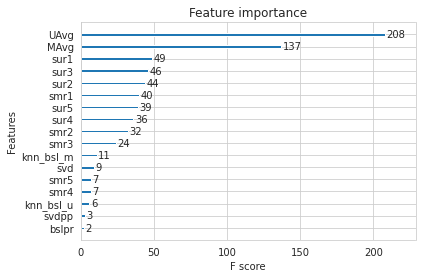

In [100]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

Training the model..
[16:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:03.575088

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0753047860953797
MAPE :  35.07058962951319


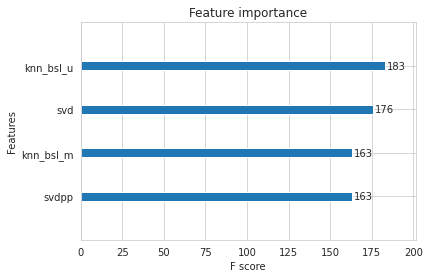

In [101]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()